In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
from utils import MattingUNet3, MattingUNetTrainerDistr, get_all_files, MattingDataset
from matplotlib import pyplot as plt
from torch import nn
import torch
from pathlib import Path

In [3]:
PREPARED_FOLDER = Path("/media/rustam/data/matting")
train_test_files = get_all_files(PREPARED_FOLDER, 11)
print(len(train_test_files))

2485


In [4]:
from sklearn.model_selection import train_test_split
train_files, test_files = train_test_split(train_test_files,  test_size=0.15, shuffle=True)

In [5]:
print(len(test_files), len(train_files))
print(test_files[0])

373 2112
(PosixPath('/media/rustam/data/matting/0083-b+'), '00627')


In [6]:
a = MattingDataset(test_files, max_files=5, th=0.1)
for data in a:
    matting, seg, image, feats, aoi = data
    print(aoi.shape)

torch.Size([1, 432, 768])
torch.Size([1, 432, 768])
torch.Size([1, 432, 768])
torch.Size([1, 432, 768])
torch.Size([1, 432, 768])


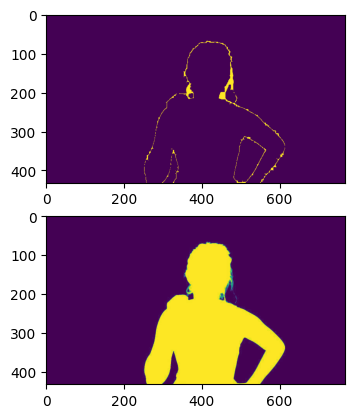

In [7]:
fig, ax = plt.subplots(2,1)
ax[0].imshow(aoi.permute(1,2,0).cpu().numpy())
ax[1].imshow(matting.permute(1,2,0).cpu().numpy())

In [8]:
from torchvision import transforms as tf


REFERENCE_FRAME = 0
NUM_POINTS = 4

IMAGE_SIZE = (200, 320)

BATCH_SIZE = 20

transform_train = tf.Compose(
    [
        tf.Resize(IMAGE_SIZE),
        tf.ElasticTransform(),
        tf.RandomPerspective(),
        tf.RandomVerticalFlip(),
        tf.RandomHorizontalFlip(),
    ]
)
transform_test = tf.Compose( [ tf.Resize(IMAGE_SIZE) ])

model = torch.nn.DataParallel(MattingUNet3(use_sigmoid=True))
# model = MattingUNet3(use_sigmoid=True).to("cuda:0")
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3)
l1_loss = nn.L1Loss(reduction='sum')

In [9]:
NAME = 'test11'
checkpoint = '0044'
MAX_FILES = 3000
SAVE_EVERY = 24

In [12]:
trainer = MattingUNetTrainerDistr(
    model=model,
    optimizer=optimizer,
    name=NAME,
    load=checkpoint,
    loss_fn=l1_loss,
    save_every=SAVE_EVERY,
    test_files=test_files,
    train_files=train_files,
    batch_size=BATCH_SIZE,
    transforms_test=transform_test,
    transforms_train=transform_train,
    max_files=MAX_FILES,
    device=torch.device("cuda:0"),
    lr=None,
)

Loading checkpoints/test11/models/0044


In [15]:
trainer.train(10)


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

train:   0%|          | 0/106 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

train:   0%|          | 0/106 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

train:   0%|          | 0/106 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

train:   0%|          | 0/106 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

train:   0%|          | 0/106 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

train:   0%|          | 0/106 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

train:   0%|          | 0/106 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

train:   0%|          | 0/106 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

train:   0%|          | 0/106 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

train:   0%|          | 0/106 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

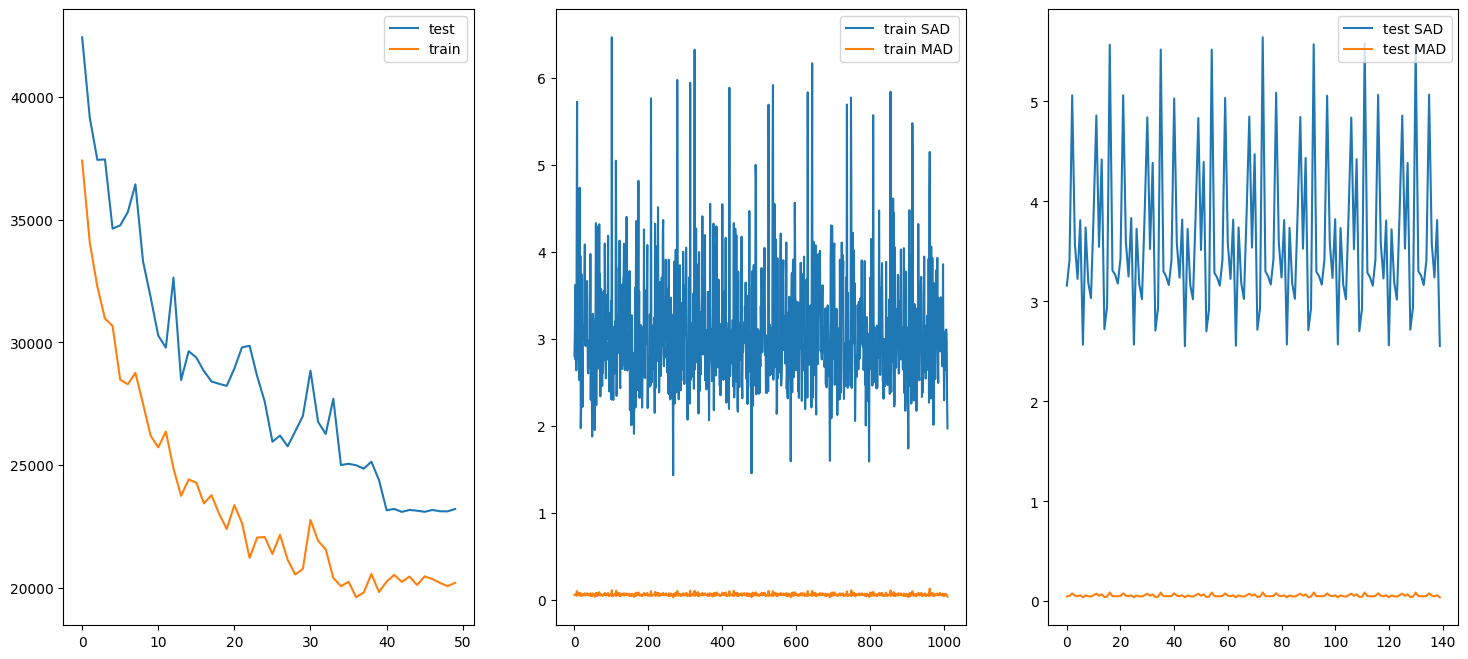

In [21]:

FROM_LOSS = 5
fig, ax = plt.subplots(1,3,figsize=(18,8))
ax[0].plot(trainer.test_losses[FROM_LOSS:], label="test")
ax[0].plot(trainer.train_losses[FROM_LOSS:], label="train")

FROM_METRIC = 50
def to_chart(who, what):
    return list(map(lambda x: x[what].sum().item() * 255, who[FROM_METRIC:]))

ax[0].legend()
ax[1].plot(to_chart(trainer.train_metrics, "sad"), label="train SAD")
ax[1].plot(to_chart(trainer.train_metrics, "mad"), label="train MAD")
ax[1].legend()
ax[2].plot(to_chart(trainer.test_metrics, "sad"), label="test SAD")
ax[2].plot(to_chart(trainer.test_metrics, "mad"), label="test MAD")
ax[2].legend()


In [22]:
list(enumerate(trainer.test_losses))

[(0, 75307.74115953948),
 (1, 59800.22635690789),
 (2, 51961.10855263158),
 (3, 48082.73601973684),
 (4, 44996.5390625),
 (5, 42444.37458881579),
 (6, 39183.15871710526),
 (7, 37444.96011513158),
 (8, 37461.97203947369),
 (9, 34638.90995065789),
 (10, 34770.52837171053),
 (11, 35310.48046875),
 (12, 36446.72286184211),
 (13, 33309.13147615131),
 (14, 31841.13363486842),
 (15, 30278.341488486843),
 (16, 29784.527138157893),
 (17, 32641.384662828947),
 (18, 28465.428762335527),
 (19, 29638.196957236843),
 (20, 29382.047902960527),
 (21, 28829.16447368421),
 (22, 28405.274465460527),
 (23, 28307.32380756579),
 (24, 28225.683490953947),
 (25, 28932.620065789473),
 (26, 29796.652857730263),
 (27, 29859.197368421053),
 (28, 28614.72738486842),
 (29, 27569.593647203947),
 (30, 25945.05191200658),
 (31, 26196.594777960527),
 (32, 25759.864309210527),
 (33, 26374.15861430921),
 (34, 26996.581722861843),
 (35, 28844.409231085527),
 (36, 26755.651418585527),
 (37, 26262.552528782893),
 (38, 27697

In [ ]:
type(list(map(lambda x: x["sad"].sum().item() * 255, trainer.train_metrics)))


In [ ]:
type(trainer.test_losses)

In [ ]:
len(trainer.train_metrics)


In [14]:
trainer.mul_lr(0.3)
trainer.get_lr()


0.0009

In [23]:

# print(vision_feats.device)
matt, pred = trainer.matting("/media/rustam/data/matting/0006-b+", "00025")


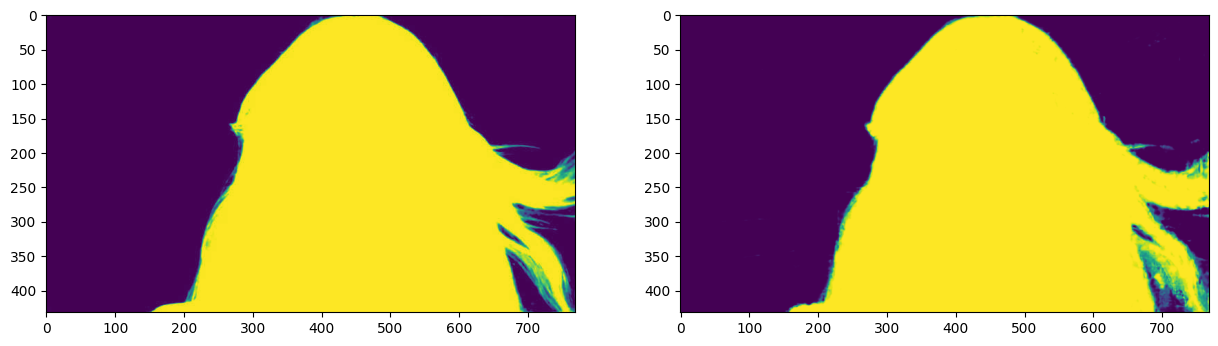

In [24]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(matt)
ax[1].imshow(pred)


In [11]:
trainer.mul_lr(0.3)
# trainer.set_lr(1e-1)

In [ ]:
trainer.get_lr()

In [ ]:
list(enumerate(trainer.test_losses))

In [25]:
for q in model.named_parameters():
    if len(q[1]) == 0:
        continue
    min = q[1].min().item()
    max = q[1].max().item()

    print(f"{'!' if min == max else ''}{q[0]}: {tuple(q[1].shape)} {min:0.4f} - {max:0.4f}")

module.enc1.0.weight: (64, 36, 3, 3) -0.0556 - 0.0556
module.enc1.0.bias: (64,) -0.0547 - 0.0528
!module.enc1.1.weight: (64,) 1.0000 - 1.0000
!module.enc1.1.bias: (64,) 0.0000 - 0.0000
module.enc1.3.weight: (64, 64, 3, 3) -0.0417 - 0.0417
module.enc1.3.bias: (64,) -0.0402 - 0.0407
!module.enc1.4.weight: (64,) 1.0000 - 1.0000
!module.enc1.4.bias: (64,) 0.0000 - 0.0000
module.enc2.0.weight: (128, 64, 3, 3) -0.0417 - 0.0417
module.enc2.0.bias: (128,) -0.0404 - 0.0414
!module.enc2.1.weight: (128,) 1.0000 - 1.0000
!module.enc2.1.bias: (128,) 0.0000 - 0.0000
module.enc2.3.weight: (128, 128, 3, 3) -0.0295 - 0.0295
module.enc2.3.bias: (128,) -0.0293 - 0.0288
!module.enc2.4.weight: (128,) 1.0000 - 1.0000
!module.enc2.4.bias: (128,) 0.0000 - 0.0000
module.enc2.6.0.weight: (128, 128, 3, 3) -0.0295 - 0.0295
module.enc2.6.0.bias: (128,) -0.0286 - 0.0292
!module.enc2.6.1.weight: (128,) 1.0000 - 1.0000
!module.enc2.6.1.bias: (128,) 0.0000 - 0.0000
module.enc3.0.weight: (256, 128, 3, 3) -0.0295 - 0.02